# Tarea 2 - Solución

## Punto 1a

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, brentq

In [7]:
def presion_vapor_sat(T):
    if (T>=0):
        es = 611 * np.exp(17.27*T/(T + 237.3))
    else:
        es = 611 * np.exp(21.87*T/(T + 265.5))
    return es

def temperature(z, T0, alpha, z0 = 0):
    T = T0 - alpha * (z - z0)
    return T

def pressure(T, T0, p0, alpha, g=9.81, R = 287):
    p = p0 * ((T + 273.15)/(T0 + 273.15)) ** (g/(alpha * R))
    return p

def latente(T):
    return 2.501 - 0.00236 * T

def rel_mezcla(e,p):
    return 0.622 * e / p

In [8]:
# datos de entrada
r0 = 12 # Relación de mezcla (g/kg)
T0 = 25 # Temperatura a nivel de superficie (°C)
p0 = 10**5 # Presión en la superficie (Pa)
H = 8 # Elevación máxima (km)
cp = 1005 # Calor específico (J/kg·K)
alpha_s = 5 # Tasa de lapso de saturación (°C/km)
alpha_as = 9.77 # Tasa de lapso adiabática (°C/km)

La primera parte consiste en determinar el nivel de saturación $z_c$. Esto ocurre cuando la relación de mezcla de saturación es igual a la relación de mezcla en la superficie, así:

In [9]:
def myfunc(x, r0, p0, T0, alpha):
    Tc = temperature(x, T0, alpha)
    Pc = pressure(Tc, T0, p0, alpha/1000)
    es = presion_vapor_sat(Tc)
    rs = 0.622 * es/Pc
    return rs - r0

zc = fsolve(myfunc, x0=1, args = (r0/1000, p0, T0, alpha_as))[0]
Tc = temperature(zc, T0, alpha_as)
Pc = pressure(Tc, T0, p0, alpha_as/1000)

print(f'El nivel de saturación es {zc:3.2f} km')
print(f'La temperatura en el nivel de saturación es {Tc:3.2f}°C')
print(f'La presión en el nivel de saturación es {Pc/1000:3.2f} kPa')

El nivel de saturación es 1.02 km
La temperatura en el nivel de saturación es 15.07°C
La presión en el nivel de saturación es 88.83 kPa


Por encima del nivel de saturación se supone que el proceso de enfriamiento es pseudo-adiabático, por lo tanto se calcula la temperatura potencial equivalente. A continuación se calcula la temperatura y presión en la elevacion máxima para determinar el $\delta r_s$

In [10]:
theta = T0 + 273.15 # Temperatura potencial (K)
theta_e = theta * np.exp(latente(Tc) * 10**6 * r0/1000 / (cp * (Tc + 273.15))) # Temperatura potencial equivalente

Tt = temperature(H, Tc, alpha_s, zc)

def func(x, T, theta_e, P0, alpha=9.77/1000, g=9.81, Ra=287, cp = 1005):
    lh = latente(T)
    es = presion_vapor_sat(T)
    rs = rel_mezcla(es, x)
    z = 1 - (T + 273.15)/theta_e * (P0 / x) ** (Ra * alpha / g) * np.exp(lh * 10**6 * rs / (cp * (T + 273.15)))
    return z

Pt = fsolve(func, x0 = Pc, args = (Tt, theta_e, p0))[0]
es = presion_vapor_sat(Tt)
rt = rel_mezcla(es, Pt) * 1000 # Relación de mezcla a la salida (g/kg)

print(f'La temperatura en el nivel máximo es {Tt:3.2f} °C')
print(f'La presión en el nivel máximo es {Pt/1000:3.2f} kPa')
print(f'La relación de mezcla es {rt:3.2f} g/kg')

La temperatura en el nivel máximo es -19.85 °C
La presión en el nivel máximo es 41.76 kPa
La relación de mezcla es 1.55 g/kg


Finalmente, se calcula el agua precipitable:

In [11]:
dr = (r0 - rt)/1000 # Cambio de relación de mezcla en kg/kg
eff = 0.2 # Eficiencia de precipitación
v = 3 # Velocidad ascensional (m/s)
Ra = 287 # Constante de gas del aire (J/kg·K)
rho_w = 1000 # Densidad del agua (kg/m3)
D = 2 # Duración de la tormenta (hr)

rho_a = Pc/(Ra * (Tc + 273.15))

i = dr * rho_a * v / rho_w * (1000 * 3600)
P = i * D * eff

print(f'El agua total precipitable es {P:3.2f} mm')

El agua total precipitable es 48.45 mm


## Punto 1b

In [12]:
def alpha(p, T):
    p = p/100
    ret = (0.002 * p + 3.9154) * np.exp(-(-6e-6 * p + 0.0208) * T)
    return ret

Perfil de columna saturada (por encima del nivel de condensación):

In [13]:
z = np.linspace(zc, H, 1000)
T_0 = Tc
p_0 = Pc
z_0 = zc

lapso = T = P = r = es = e = rh = []

for z_i in z:
    alpha_i = alpha(p_0, T_0)
    T_i = temperature(z_i, T_0, alpha_i, z_0)
    P_i = fsolve(func, x0 = p_0, args = (T_i, theta_e, p0))[0]
        
    es_i = presion_vapor_sat(T_i)
    r_i = rel_mezcla(es_i, P_i)
    
    lapso = lapso + [alpha_i]
    T = T + [T_i]
    P = P + [P_i]
    es = es + [es_i]
    r = r + [r_i]
    rh = rh + [100]
    e = e + [es_i]
    
    p_0 = P_i
    T_0 = T_i
    z_0 = z_i

Perfi de la columna no saturada (por debajo del nivel de condensación)

In [14]:
za = np.linspace(0, zc, 1000)
Ta = temperature(za, T0, alpha_as)
Pa = pressure(Ta, T0, p0, alpha_as/1000)
esa = np.array([presion_vapor_sat(T_i) for T_i in Ta])

e0 = r0/1000 * p0 / 0.622
ea = pressure(Ta, T0, e0, alpha_as/1000, R=287) # Debido a la aproximación de que rs_c = r0, se debe usar R = Ra (y no R = Rv) para que los perfiles cierren
ra = rel_mezcla(ea, Pa)

rha = ea/esa * 100

### Figuras

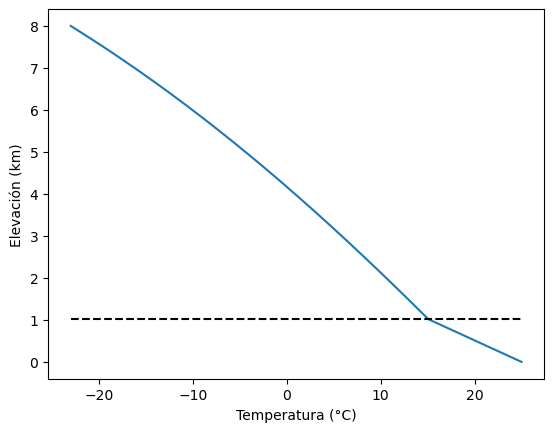

In [17]:
zp = np.hstack([za, z])
Tp = np.hstack([Ta, np.array(T)])

plt.plot(Tp,zp)
plt.plot([min(Tp), max(Tp)], [zc, zc], 'k--')
plt.ylabel('Elevación (km)')
plt.xlabel('Temperatura (°C)')
plt.show()

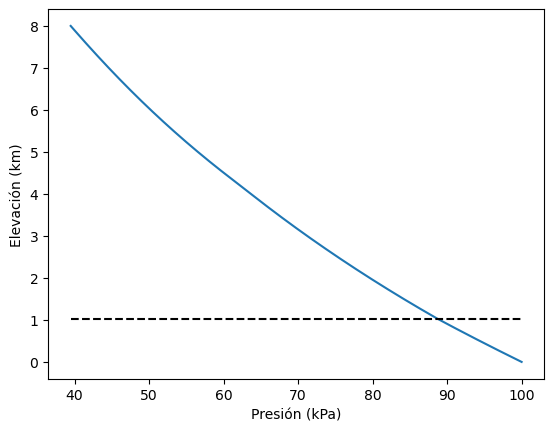

In [18]:
Pp = np.hstack([Pa, np.array(P)])

plt.plot(Pp/1000,zp)
plt.plot([min(Pp/1000), max(Pp/1000)], [zc, zc], 'k--')
plt.ylabel('Elevación (km)')
plt.xlabel('Presión (kPa)')
plt.show()

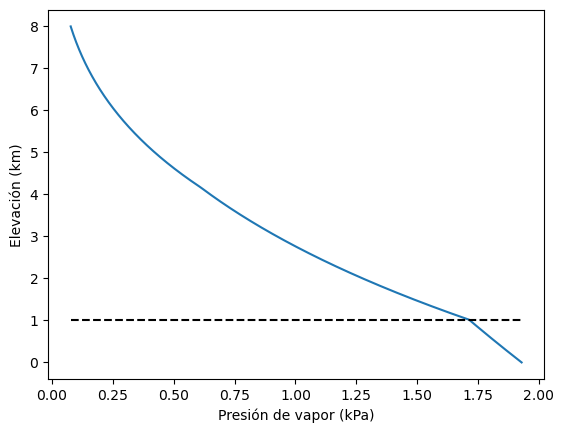

In [19]:
ep = np.hstack([ea, np.array(e)])

plt.plot(ep/1000,zp)
plt.plot([min(ep/1000), max(ep/1000)], [zc, zc], 'k--')
plt.ylabel('Elevación (km)')
plt.xlabel('Presión de vapor (kPa)')
plt.show()

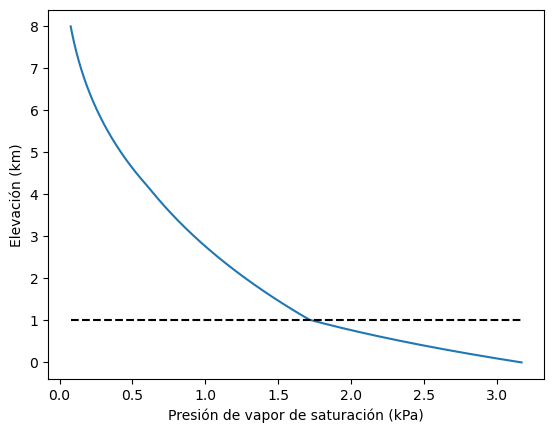

In [20]:
esp = np.hstack([esa, np.array(es)])

plt.plot(esp/1000,zp)
plt.plot([min(esp/1000), max(esp/1000)], [zc, zc], 'k--')
plt.ylabel('Elevación (km)')
plt.xlabel('Presión de vapor de saturación (kPa)')
plt.show()

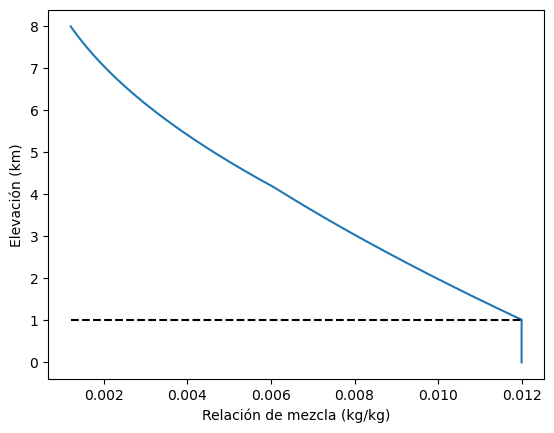

In [22]:
rp = np.hstack([ra, np.array(r)])

plt.plot(rp,zp)
plt.plot([min(rp), max(rp)], [zc, zc], 'k--')
plt.ylabel('Elevación (km)')
plt.xlabel('Relación de mezcla (kg/kg)')
plt.show()

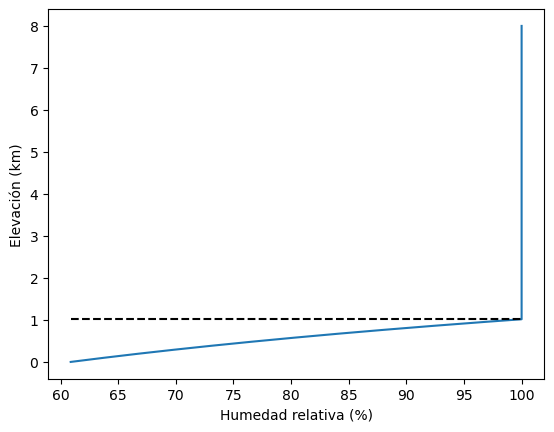

In [23]:
rhp = np.hstack([rha, np.array(rh)])

plt.plot(rhp,zp)
plt.plot([min(rhp), max(rhp)], [zc, zc], 'k--')
plt.ylabel('Elevación (km)')
plt.xlabel('Humedad relativa (%)')
plt.show()